In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stat
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import math
from collections import defaultdict

In [2]:
from research.strings import VIOLATIONS, MONTHS

In [3]:
df_canvass = pd.read_csv("data/canvass_records.csv.gz")
df_canvass["critical_found"] = df_canvass[VIOLATIONS].max(axis=1)
df_canvass["aka_name"] = df_canvass["aka_name"].fillna("NULL_NAME")
print("Read {} canvass records.".format(len(df_canvass)))

Read 50462 canvass records.


In [6]:
def get_mode(df, lid, col):
    ser = df.query("license_id == {}".format(lid))[col]
    mode = ser.mode()[0]
    mode_count = sum([n == mode for n in ser])
    return mode, mode_count, ser

In [7]:
lid_res = []
lid_map = {}
addr_map = {}
lids = np.unique(df_canvass["license_id"])
for lid in lids:
    mode_name, mode_name_count, name_ser = get_mode(df_canvass, lid, "aka_name")
    mode_addr, mode_addr_count, addr_ser = get_mode(df_canvass, lid, "address")
    lid_res.append((lid, mode_name, mode_name_count, mode_addr, mode_addr_count, len(name_ser)))
    lid_map[lid] = mode_name
    addr_map[lid] = mode_addr

In [8]:
lid_cols = ["license_id", "mode_name", "mode_name_count", "mode_addr", "mode_addr_count", "name_count"]
lid_df = pd.DataFrame(lid_res, columns=lid_cols)
lid_df.head()

,license_id,mode_name,mode_name_count,mode_addr,mode_addr_count,name_count
0,0,NULL_NAME,2,,1,25
1,2,COSI,11,230 W MONROE ST,11,11
2,9,XANDO COFFEE & BAR / COSI SANDWICH BAR,10,116 S MICHIGAN AVE,10,10
3,40,COSI,7,233 N MICHIGAN AVE,7,7
4,62,XANDO COFFEE & BAR / COSI SANDWICH BAR,12,230 W WASHINGTON ST,12,12


In [9]:
def get_month_rates(v_map, prefix, min_samples=2):
    months = list(filter(lambda p: len(p[1]) >= min_samples, v_map.items()))
    if len(months) < 1:
        return {
            "{}_hi_month".format(prefix): None,
            "{}_hi_rate".format(prefix): None,
            "{}_lo_month".format(prefix): None,
            "{}_lo_rate".format(prefix): None,
            "{}_n_months".format(prefix): None,
            "{}_n_inspecs".format(prefix): None
        }
    n_inspecs = sum([len(a) for m, a in months])
    hit_rates = [(m, (sum(a) / len(a))) for m, a in months]
    ranked = sorted(hit_rates, key=lambda p: p[1], reverse=True)
    res = {
        "{}_hi_month".format(prefix): ranked[0][0],
        "{}_hi_rate".format(prefix): ranked[0][1],
        "{}_lo_month".format(prefix): ranked[-1][0],
        "{}_lo_rate".format(prefix): ranked[-1][1],
        "{}_n_months".format(prefix): len(ranked),
        "{}_n_inspecs".format(prefix): n_inspecs
    }
    return res

In [10]:
def get_license_month_rates(recs, target):
    v_dict = defaultdict(lambda: defaultdict(lambda: []))
    for r in recs:
        period = "after" if r["year"] >= 2015 else "before"
        v_dict[period][r["month"]].append(r[target])
    r1 = get_month_rates(v_dict["before"], "before")
    r2 = get_month_rates(v_dict["after"], "after")
    r1.update(r2)
    return r1

In [11]:
target = "V3"
gp = df_canvass.groupby("license_id")[["year", "month", target]]
table = gp.apply(lambda p: get_license_month_rates(p.to_dict(orient="records"), target))

In [12]:
# Period = before (2010 - 2014) or after (2015 - 2018) model deployment
# Valid month = a month where the location had at least two inspections over
# the years in the period
full_df = pd.DataFrame(list(table.values))
comp_cols = ["license_id", "aka_name"] + list(full_df.columns)
full_df["license_id"] = list(table.index)
full_df["aka_name"] = full_df["license_id"].apply(lambda lid: lid_map[lid])
full_df = full_df[comp_cols]
# Filter only licenses with at least one valid month 
comp_df = full_df.dropna()
# Filter only licenses with at least two valid months in each period
supp_df = pd.DataFrame(comp_df.query("after_n_months > 1 and before_n_months > 1"))
supp_df.head()

,license_id,aka_name,after_hi_month,after_hi_rate,after_lo_month,after_lo_rate,after_n_inspecs,after_n_months,before_hi_month,before_hi_rate,before_lo_month,before_lo_rate,before_n_inspecs,before_n_months
0,0,NULL_NAME,9.0,0.5,6.0,0.0,8.0,3.0,9.0,0.5,7.0,0.0,9.0,4.0
829,25081,THE PATIO BAR,5.0,0.5,6.0,0.0,4.0,2.0,3.0,0.0,4.0,0.0,4.0,2.0
830,25082,BARDS ROOM KITCHEN/PRESS/INVESTOR DINING ROOMS,6.0,0.0,5.0,0.0,4.0,2.0,3.0,0.0,4.0,0.0,4.0,2.0
977,29570,EFIE'S CANTEEN (TAXI/LIMO AREA),10.0,0.0,4.0,0.0,4.0,2.0,6.0,0.0,12.0,0.0,4.0,2.0
1157,34185,WICKER PARK SEAFOOD AND SUSHI BAR (T2 MAIN HALL),5.0,0.0,8.0,0.0,4.0,2.0,8.0,0.0,12.0,0.0,4.0,2.0


In [13]:
len(full_df), len(comp_df), len(supp_df)

(12057, 797, 19)

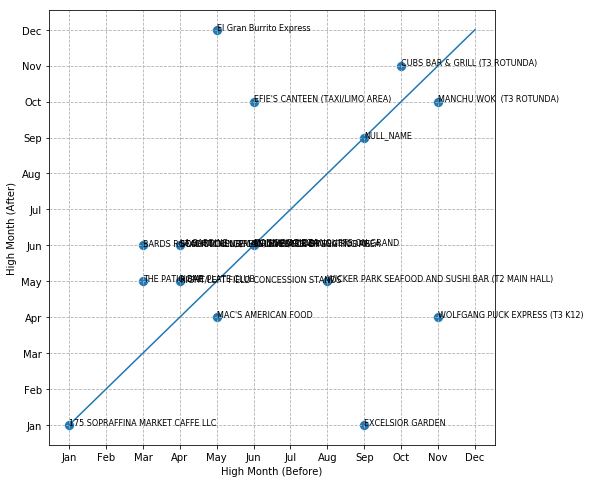

In [30]:
sns.scatterplot(x="before_hi_month", y="after_hi_month", s=100, data=supp_df)
sns.lineplot(range(1, len(MONTHS) + 1), range(1, len(MONTHS) + 1))
plt.xticks(range(1, len(MONTHS) + 1), MONTHS)
plt.yticks(range(1, len(MONTHS) + 1), MONTHS)
plt.xlabel("High Month (Before)")
plt.ylabel("High Month (After)")
for r in supp_df.to_dict(orient="records"):
    plt.text(r["before_hi_month"], r["after_hi_month"], lid_map[r["license_id"]], fontsize=8)
plt.grid(linestyle="--")
plt.gcf().set_size_inches(8, 8)
plt.show()

In [15]:
supp_df

,license_id,aka_name,after_hi_month,after_hi_rate,after_lo_month,after_lo_rate,after_n_inspecs,after_n_months,before_hi_month,before_hi_rate,before_lo_month,before_lo_rate,before_n_inspecs,before_n_months
0,0,NULL_NAME,9.0,0.5,6.0,0.0,8.0,3.0,9.0,0.5,7.0,0.0,9.0,4.0
829,25081,THE PATIO BAR,5.0,0.5,6.0,0.0,4.0,2.0,3.0,0.0,4.0,0.0,4.0,2.0
830,25082,BARDS ROOM KITCHEN/PRESS/INVESTOR DINING ROOMS,6.0,0.0,5.0,0.0,4.0,2.0,3.0,0.0,4.0,0.0,4.0,2.0
977,29570,EFIE'S CANTEEN (TAXI/LIMO AREA),10.0,0.0,4.0,0.0,4.0,2.0,6.0,0.0,12.0,0.0,4.0,2.0
1157,34185,WICKER PARK SEAFOOD AND SUSHI BAR (T2 MAIN HALL),5.0,0.0,8.0,0.0,4.0,2.0,8.0,0.0,12.0,0.0,4.0,2.0
1161,34199,WOLFGANG PUCK EXPRESS (T3 K12),4.0,0.0,9.0,0.0,4.0,2.0,11.0,0.0,6.0,0.0,5.0,2.0
1267,36651,CONNIE'S PIZZA,6.0,0.5,3.0,0.0,5.0,2.0,6.0,0.5,4.0,0.0,4.0,2.0
1516,44811,MAGGIANO'S BANQUETS ON GRAND,6.0,0.5,5.0,0.0,4.0,2.0,6.0,0.0,9.0,0.0,4.0,2.0
1882,65747,LA SARDINE,6.0,0.5,3.0,0.0,4.0,2.0,4.0,0.0,6.0,0.0,5.0,2.0
2079,80542,MAC'S AMERICAN FOOD,4.0,0.0,8.0,0.0,4.0,2.0,5.0,0.0,8.0,0.0,4.0,2.0


In [16]:
def get_month_series(mdf, target):
    gpby = mdf.groupby("month")[target].mean()
    month_idxs = list(range(1, len(MONTHS) + 1))
    return month_idxs, [gpby[m] if m in gpby else 0 for m in month_idxs]

In [17]:
def plot_comparison(df_canvass, rest_lid, target):
    rdf = df_canvass.query("license_id == {}".format(rest_lid))
    rdf_after = rdf.query("year >= 2015")
    rdf_before = rdf.query("year < 2015")
    pal = sns.color_palette("hls", 2)
    x_before, y_before = get_month_series(rdf_before, target)
    x_after, y_after = get_month_series(rdf_after, target)
    sns.lineplot(x_before, y_before, label="Before", color=pal[0])
    sns.lineplot(x_after, y_after, label="After", color=pal[1])
    chart_title = "Violation: {}\n{}\n{}\nLicense ID: {}, Before = {}, After = {}"
    vals = target, lid_map[rest_lid], addr_map[rest_lid], rest_lid, len(rdf_before), len(rdf_after)
    plt.title(chart_title.format(*vals))
    plt.xticks(range(1, len(MONTHS) + 1), MONTHS)
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.legend()
    plt.gcf().set_size_inches(8, 5)
    plt.show()

In [18]:
def get_month_counts(mdf, target):
    gpby = mdf.groupby("month")[target].count()
    month_idxs = list(range(1, len(MONTHS) + 1))
    return month_idxs, [gpby[m] if m in gpby else 0 for m in month_idxs]

In [48]:
def plot_comparison(df_canvass, rest_lid, target):
    rdf = df_canvass.query("license_id == {}".format(rest_lid))
    rdf_after = rdf.query("year >= 2015")
    rdf_before = rdf.query("year < 2015")
    pal = sns.color_palette("hls", 2)
    x_before, y_before = get_month_series(rdf_before, target)
    x_after, y_after = get_month_series(rdf_after, target)
    sns.lineplot(x_before, y_before, label="Before", color=pal[0])
    sns.lineplot(x_after, y_after, label="After", color=pal[1])
    chart_title = "Violation: {}\n{}\n{}\nLicense ID: {}, Before = {}, After = {}"
    vals = target, lid_map[rest_lid], addr_map[rest_lid], rest_lid, len(rdf_before), len(rdf_after)
    plt.title(chart_title.format(*vals))
    plt.xticks(range(1, len(MONTHS) + 1), MONTHS)
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.legend()
    plt.gcf().set_size_inches(8, 5)
    plt.show()

In [83]:
def plot_inspections(focus_lid):
    focus_targets = ["critical_found", "V2", "V3"]
    rest_df = df_canvass.query("license_id == {}".format(focus_lid))
    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.swarmplot(
        x="year", y="month",
        hue="critical_found",
        data=rest_df,
        palette=sorted(sns.color_palette("hls", 2)),
        ax=ax1, s=8,
    )
    pal = sns.color_palette("hls", len(focus_targets))
    for ft, c in zip(focus_targets, pal):
        cf_tab = rest_df.groupby("year")[ft].mean()
        sns.lineplot(cf_tab.index, cf_tab.values, ax=ax2, label=ft, color=c)
    ax1.legend(title="Critical Found", ncol=2, bbox_to_anchor=(0.65, -0.25))
    ax1.set_yticks(range(1, len(MONTHS) + 1))
    ax1.set_yticklabels(MONTHS)
    ax1.set_xlabel("Year")
    ax1.set_ylabel("Month")
    ax1.set_title("Swarmplot of Inspections")
    ax1.grid(linestyle="--")
    ax2.legend(title="Series", ncol=3, bbox_to_anchor=(0.83, -0.25))
    ax2.set_xlabel("Year")
    ax2.set_ylabel("Hit Rate")
    ax2.set_title("Annual Hit Rate")
    ax2.grid(linestyle="--")
    vals = lid_map[focus_lid], addr_map[focus_lid], focus_lid
    chart_title = "{}\n{}, License ID: {}".format(*vals)
    fig.suptitle(chart_title)
    plt.subplots_adjust(top=0.75)
    plt.gcf().set_size_inches(14, 3)
    plt.show()

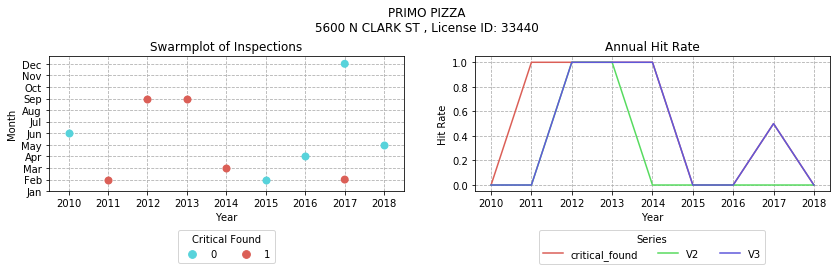

In [84]:
plot_inspections(33440)

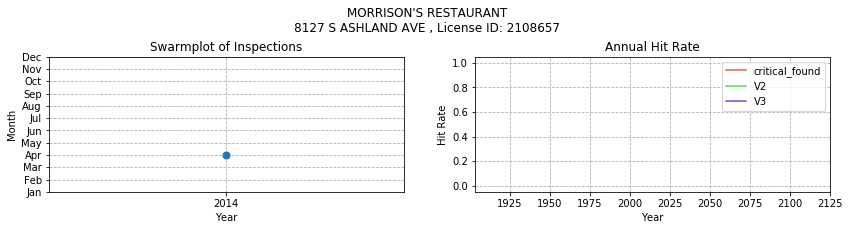

In [32]:
plot_inspections(2108657)

In [24]:
records = df_canvass.to_dict(orient="record")
df_canvass["hit_before"] = [r["critical_found"] if r["year"] < 2015 else 0 for r in records]
df_canvass["hit_after"] = [r["critical_found"] if r["year"] >= 2015 else 0 for r in records]

In [35]:
aggs = [np.mean, np.sum]
gp_change = df_canvass.groupby("license_id")["hit_before", "hit_after", "year"].agg({
    "hit_before": aggs,
    "hit_after": aggs,
    "year": [lambda ser: len(np.unique(ser))]
})
cols_change = [
    "hit_rate_before",
    "hit_count_before",
    "hit_rate_after",
    "hit_count_after",
    "unique_years"
]
df_change = pd.DataFrame(gp_change.values, columns=cols_change)
df_change["license_id"] = list(gp_change.index)
df_change["aka_name"] = df_change["license_id"].apply(lambda lid: lid_map[lid])
df_change["change"] = abs(df_change["hit_rate_after"] - df_change["hit_rate_before"])
df_change["change_count"] = abs(df_change["hit_count_after"] - df_change["hit_count_before"])

In [36]:
df_change.head()

,hit_rate_before,hit_count_before,hit_rate_after,hit_count_after,unique_years,license_id,aka_name,change,change_count
0,0.240000,6.0,0.200000,5.0,8.0,0,NULL_NAME,0.040000,1.0
1,0.090909,1.0,0.272727,3.0,9.0,2,COSI,0.181818,2.0
2,0.000000,0.0,0.300000,3.0,7.0,9,XANDO COFFEE & BAR / COSI SANDWICH BAR,0.300000,3.0
3,0.000000,0.0,0.000000,0.0,7.0,40,COSI,0.000000,0.0
4,0.000000,0.0,0.250000,3.0,9.0,62,XANDO COFFEE & BAR / COSI SANDWICH BAR,0.250000,3.0


In [92]:
top = df_change.sort_values(
    by=["unique_years", "hit_count_before"],
    ascending=[False, False]
)
print("{} licenses with inspections every year.".format(len(top.query("unique_years == 9"))))
top.head(10)

341 licenses with inspections every year.


,hit_rate_before,hit_count_before,hit_rate_after,hit_count_after,unique_years,license_id,aka_name,change,change_count
1116,0.400000,4.0,0.100000,1.0,9.0,33440,PRIMO PIZZA,0.300000,3.0
1623,0.333333,4.0,0.166667,2.0,9.0,49607,TAQUERIA LA CHIQUITA,0.166667,2.0
4059,0.363636,4.0,0.272727,3.0,9.0,1680379,TOWN HOUSE RESTAURANT & WINE BAR,0.090909,1.0
470,0.272727,3.0,0.363636,4.0,9.0,14134,MY THAI - TAKUMI RESTAURANT,0.090909,1.0
895,0.272727,3.0,0.090909,1.0,9.0,26898,VEE-VEE'S AFRICAN RESTAURANT,0.181818,2.0
1166,0.187500,3.0,0.125000,2.0,9.0,34210,BRIOCHE DOREE (T3/G/ROTUNDA),0.062500,1.0
1578,0.272727,3.0,0.090909,1.0,9.0,47512,JAIMITOS BURRITOS,0.181818,2.0
4539,0.272727,3.0,0.000000,0.0,9.0,1804387,HOME PLATE CLUB,0.272727,3.0
4683,0.333333,3.0,0.333333,3.0,9.0,1823680,THE FOUR SEASONS HOTEL CHICAGO,0.000000,0.0
4854,0.333333,3.0,0.111111,1.0,9.0,1869112,JOHN'S PLACE,0.222222,2.0


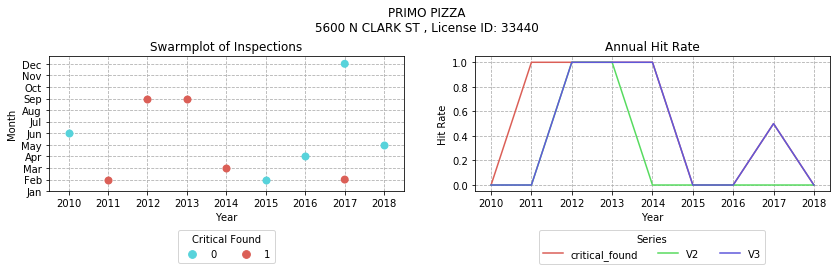

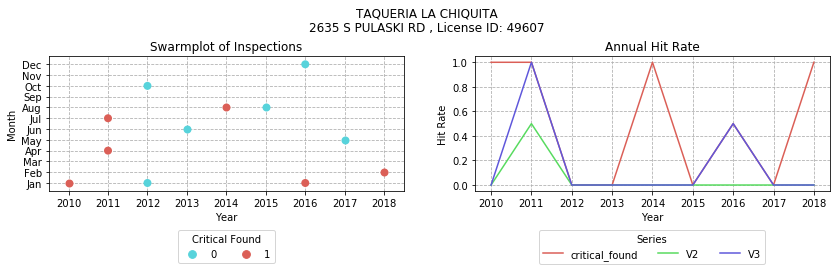

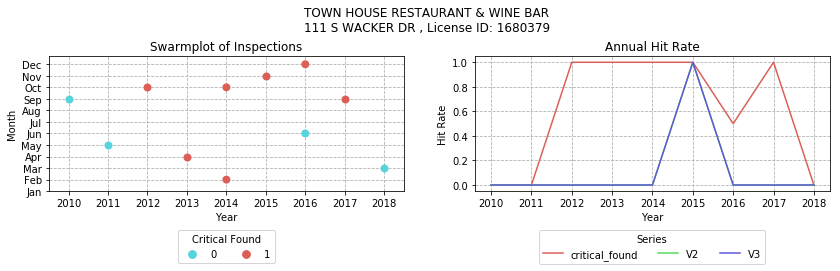

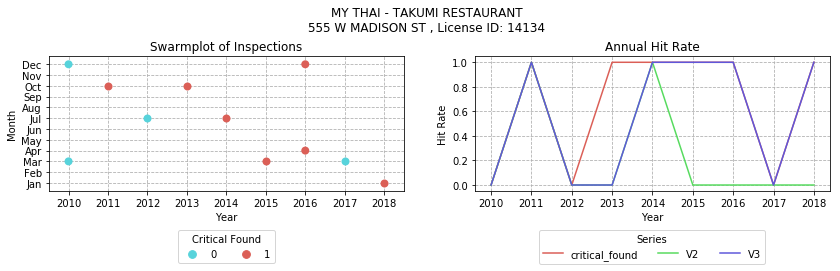

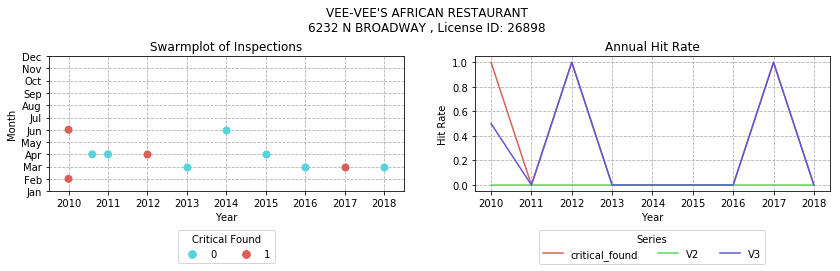

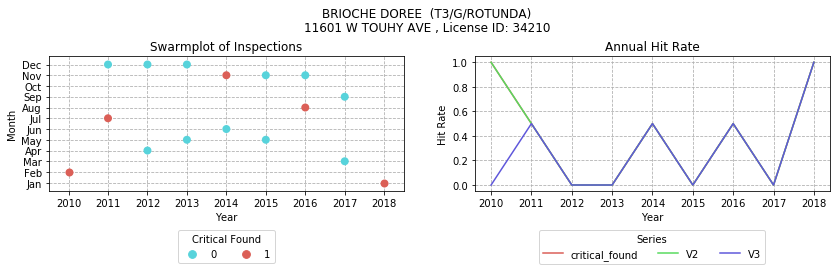

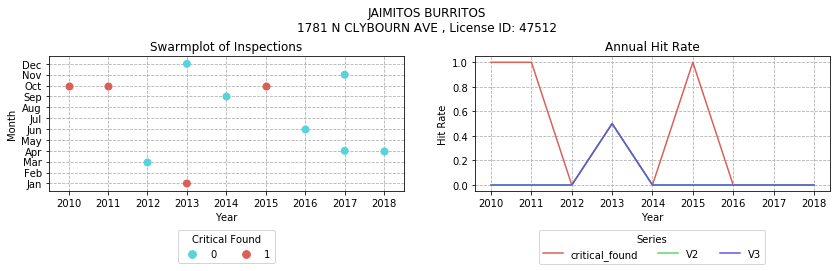

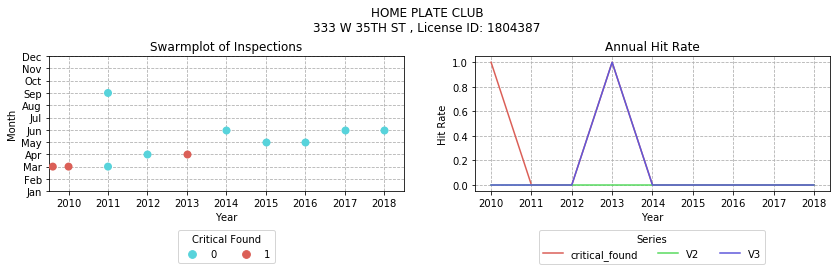

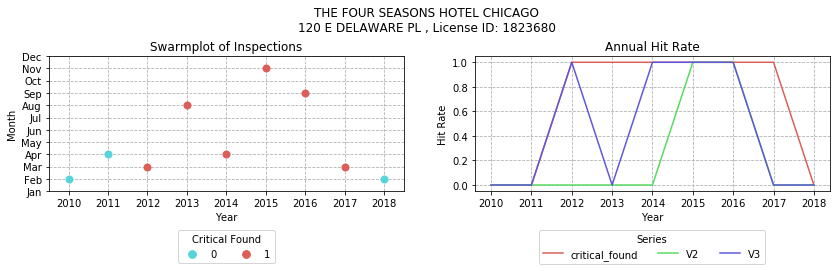

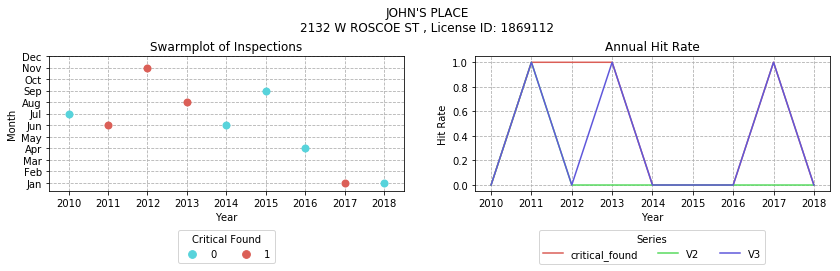

In [91]:
for lid in top["license_id"].values[:10]:
    plot_inspections(lid)

In [28]:
df_canvass.query("license_id == 2026186")

,inspection_id,address,aka_name,city,dba_name,facility_type,inspection_date,inspection_type,latitude,license_id,...,V8,V9,V10,V11,V12,V13,V14,critical_found,hit_before,hit_after
